# Introduction

Predicting financial indicators is definitely a holy grail for our society at its present stage. There is a vast literature on how to do this and the general approach is a time-series one, that is, predict the future of one quantity based on that quantity's past.

We are trying to see if it's possible to complement this approach with data coming from news sources, reasoning that news from the world should directly and indirectly weigh on the performance of such indicators as stocks, employment rate, or inflation.

Please keep in mind that we do not expect to make any significant improvement over state-of-the-art financial analyses (which involve much more complex and refined models). Rather, we are interested in building a scalable and dynamic pipeline that in the future might supplement those already-existing models or give interesting insights.

### This notebook

This is a walkthrough illustrating the typical usage of our package. We will try to predict future S&P500 closing values based on past S&P500 values along with NLP features extracted from the daily-updted GDELT 1.0 (http://www.gdeltproject.org/) event database.

In particular, to scope down the analysis to a minimally viable scalable pipeline, I extract features from the source urls contained in the database (one associated to each event).

For each day, all urls get parsed, tokenized, and stemmed, and then conflated together into a single bag of words. This will constitute one document. After that I may apply a tf-idf or word2vec vectorization (this latter being much favored).

I use the extracted features (plus the same day's closing S&P500) to try and fit various regression models to predict the next day's S&P500 and compare them to a benchmark model (a simple naive model predicting the same for tomorrow as today, plus the average increase or decrease over the last few days).

I also try to predict if tomorrow's index value will rise or fall, given today's news.

For both tasks random forest regressors/classifiers seem promising approaches.

In [1]:
import importlib
import sys
import os
sourcedir=os.getcwd()+"/../source"
if sourcedir not in sys.path:
    sys.path.append(sourcedir)
import numpy as np

In [2]:
#importing our nlp proprocessing module, the reload command is for development
import nlp_preprocessing as nlpp
importlib.reload(nlpp)
#importing our model training module, the reload command is for development
import model_training as mdlt
importlib.reload(mdlt)

<module 'model_training' from '/Users/Maxos/Desktop/Insight_stuff/bigsnippyrepo/maqro/notebooks/../source/model_training.py'>

## The nlp-preprocessing module

The module has two classes for now: one deals with the nlp preprocessing of Google News articles, which are talked about in much more depth in another notebook; the other is the analog for GDELT url data.

Let's explore these classes and their contents.

### The CorpusGoogleNews class

In [13]:
#del datagnews
datagnews=nlpp.CorpusGoogleNews() # nlpp.CorpusGoogleNews('some/data/directory') 

These are the attributes of the initialized class

In [4]:
datagnews.raw_articles

{}

In [5]:
datagnews.datadirectory

'../data/'

There is one public method for now: it loads files from the data folder

In [6]:
datagnews.data_directory_crawl('AAPL',verbose=1)

Apple Inc
Apple Inc 1-26-17
Apple Inc 1-27-17
Apple Inc 1-30-17
Apple Inc 1-31-17
Apple Inc 2-1-17


which populates datagnews.raw_articles with dataframes like this:

In [7]:
datagnews.raw_articles['Apple Inc 1-30-17'].head()

,body,category,title
0,The first day of public trading with President...,Apple Inc,3 Stocks to Watch on Tuesday: Apple Inc. (AAPL...
1,The first day of public trading with President...,Apple Inc,3 Stocks to Watch on Tuesday: Apple Inc. (AAPL...
2,"The smart home market continues to heat up, an...",Apple Inc,Alphabet Inc (GOOGL) Steals AI Expert Back Fro...
3,"Reportedly, Apple Inc.’s AAPL management is sc...",Apple Inc,Apple (AAPL) Set to Meet Government Officials ...
4,Apple Inc. (AAPL) executives were in India tod...,Apple Inc,Apple Close to Signing Deal With Indian Govern...


### The CorpusGDELT class

Let's initialize the class

In [3]:
#del datagdelt
datagdelt=nlpp.CorpusGDELT(min_ment=500) # min_ment defaults to 1 and cuts off events that have a low number of mentions

Let's have a look at the several attributes that the class contains.

In [4]:
#minimum number of mentions for one event to be used
print('Minimum number of mentions:',datagdelt.minimum_ment)
print('Current directory:',datagdelt.currentdir) # current directory
print('Dates loaded so far:',datagdelt.dates) # dates for which data has been loaded so far
print('Corpus of raw urls',datagdelt.url_corpus)
print('Corpus of tfidf-vectorized docs:')
print(datagdelt.vect_corpus_tfidf)

Minimum number of mentions: 500
Current directory: ../data/GDELT_1.0/
Dates loaded so far: []
Corpus of raw urls []
Corpus of tfidf-vectorized docs:
Empty DataFrame
Columns: []
Index: []


In [5]:
#vowels and consonants
print('Vowels:',datagdelt.vowels)
print('Consonants:',datagdelt.consonants,end=' ')
print()
print('Stemmer:',datagdelt.porter) #stemmer of choice
print('Punctuation:',datagdelt.punctuation) #punctuation regular expression
print('Tokenizer:',datagdelt.re_tokenizer) 
print('Filter for spurious url beginnings:',datagdelt.spurious_beginnings)
print('Filter for stop words:',datagdelt.stop_words)

Vowels: ['a', 'e', 'i', 'o', 'u', 'y']
Consonants: ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'z'] 
Stemmer: <PorterStemmer>
Punctuation: re.compile('[-.?!,":;()|0-9]')
Tokenizer: RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=56)
Filter for spurious url beginnings: re.compile('idind.|idus.|iduk.')
Filter for stop words: {'they', '', 'before', 'o', 'than', 'couldn', 'isn', 'shouldn', 'm', 'until', 'their', 'a', 'my', 'but', 'in', 'hadn', 'them', 'now', 'for', 'most', 'doesn', 'again', 'won', 'wouldn', 'while', 'how', 'himself', 'ourselves', 'have', 'any', 'between', 'who', 'why', 'should', 'shan', 'whom', 'just', 'it', 'not', 'the', 'does', 'you', 'ours', 'here', 'its', 'these', 'yours', 'am', 'nor', 'which', 'about', 'has', 'over', 'on', 'having', 'd', 'she', 'out', 'down', 'mightn', 'll', 've', 'at', 'all', 'her', 'hasn', 'doing', 'did', 'too', 'we', 'so', 's', 'wasn', 'yourselves', 'during', 'needn', 'furthe

In [6]:
print(datagdelt.header,end=' ') #GDELT csv files header, notice the last field has the urls

['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode', 'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code', 'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode', 'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code', 'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent', 'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID', 'ActionGeo_Type', 'ActionGeo_FullName', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 'ActionGeo_Lat', 

Now let's see what methods are available and what the pipeline is like.

First we load the urls.

In [4]:
datagdelt.load_urls('20161001','20170220') #the earliest available date is April 1st 2013 = 20130401

 Done!

Now let's look at what the url_corpus attribute looks like

In [8]:
day=5 #select one day
print('There are',len(datagdelt.url_corpus),'elements in it, because we loaded',len(datagdelt.dates),'days!')
print('The loaded day n.',day,'had',len(datagdelt.url_corpus[day-1]) ,'events in it that were mentioned more than',datagdelt.minimum_ment,'times:\n', datagdelt.url_corpus[day-1][:10],'\n etc...')
print('The first event was mentioned',datagdelt.url_corpus[day-1][0][0],'times, the second',datagdelt.url_corpus[day-1][1][0],'times, etc...')

There are 142 elements in it, because we loaded 142 days!
The loaded day n. 5 had 653 events in it that were mentioned more than 500 times:
 [[1972, 'http://www.philippinetimes.com/index.php/sid/248243461'], [1115, 'http://www.capradio.org/news/npr/story?storyid=496552413'], [970, 'http://thecabin.net/news/2016-10-04/dazzle-daze-raffle-tickets-sale'], [660, 'http://www.princegeorgecitizen.com/celebrity-chef-jamie-oliver-hopes-to-discuss-child-health-issues-with-trudeau-1.2358050'], [748, 'http://1045snx.iheart.com/articles/trending-104650/spencer-pratt-mocks-kim-kardashian-robbery-15169059/'], [746, 'https://in.news.yahoo.com/may-woo-labour-voters-pitch-britains-center-ground-230645420.html'], [754, 'http://www.stuff.co.nz/entertainment/84945059/Veteran-broadcaster-Mark-Sainsbury-takes-Rocky-Horror-Stage-in-Hamilton'], [1951, 'http://www.whio.com/news/national-govt--politics/clinton-reaches-out-women-while-trump-defends-taxes/xnmN5QugmLzeGkEBR64y9I/'], [1965, 'http://wgno.com/2016/10/0

We see that many of those urls contain wordings that can be very informative on what's happening in the world and therefore might tell us something about the near future of the markets!!

Now, let's process these messy raw urls! Let's use word2vec:

In [5]:
datagdelt.gdelt_preprocess(vectrz='word2vec',size_w2v=16)

Using word2vec vectorization procedure


2017-02-21 07:47:13,423 : INFO : collecting all words and their counts
2017-02-21 07:47:13,425 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-21 07:47:13,532 : INFO : collected 20544 word types from a corpus of 491097 raw words and 143 sentences
2017-02-21 07:47:13,533 : INFO : Loading a fresh vocabulary
2017-02-21 07:47:13,615 : INFO : min_count=1 retains 20544 unique words (100% of original 20544, drops 0)
2017-02-21 07:47:13,616 : INFO : min_count=1 leaves 491097 word corpus (100% of original 491097, drops 0)
2017-02-21 07:47:13,726 : INFO : deleting the raw counts dictionary of 20544 items
2017-02-21 07:47:13,730 : INFO : sample=0.001 downsamples 24 most-common words
2017-02-21 07:47:13,731 : INFO : downsampling leaves estimated 466367 word corpus (95.0% of prior 491097)
2017-02-21 07:47:13,732 : INFO : estimated required memory for 20544 words and 16 dimensions: 12901632 bytes
2017-02-21 07:47:13,817 : INFO : resetting layer weights
2017-02-21 0

which gives

In [76]:
datagdelt.word2vec_corpus.head(10)

,w2v_1,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9
news_date,,,,,,,,,,,,,,,,
20161001,0.147216,0.251865,-0.284941,0.242540,-0.057002,-0.311548,-0.222425,0.012351,0.428797,-0.112210,-0.136568,-0.124081,0.324815,-0.007943,-0.526253,0.109189
20161002,0.158100,0.275931,-0.292214,0.221198,-0.063839,-0.238000,-0.198797,0.050775,0.394337,-0.160199,-0.185486,-0.124969,0.319291,-0.027109,-0.570227,0.051987
20161003,0.112319,0.248640,-0.288407,0.243337,-0.062513,-0.260392,-0.213616,0.061955,0.419636,-0.137138,-0.166626,-0.125741,0.359496,-0.035961,-0.539379,0.045304
20161004,0.079911,0.236776,-0.299086,0.234542,-0.073904,-0.277271,-0.237542,0.077051,0.432817,-0.129468,-0.155965,-0.137235,0.345620,-0.006399,-0.528726,0.045705
20161005,0.118022,0.250526,-0.301300,0.235911,-0.077778,-0.268216,-0.250419,0.051513,0.445433,-0.120880,-0.173388,-0.118524,0.305604,0.029072,-0.526389,0.071140
20161006,0.108711,0.253770,-0.271948,0.228161,-0.059861,-0.272070,-0.190920,0.027294,0.414371,-0.127463,-0.167927,-0.137831,0.325411,-0.050473,-0.580435,0.049772
20161007,0.099313,0.252881,-0.290870,0.219011,-0.082661,-0.266230,-0.225134,0.043306,0.444375,-0.116432,-0.179524,-0.130188,0.299229,-0.002966,-0.555643,0.069679
20161008,0.131393,0.226722,-0.272162,0.239536,-0.099648,-0.239402,-0.193977,0.138558,0.422528,-0.182143,-0.195920,-0.097964,0.312344,-0.071248,-0.558480,0.039902
20161009,0.135325,0.211436,-0.296153,0.213354,-0.060613,-0.310289,-0.223064,0.063030,0.457677,-0.098836,-0.123826,-0.110151,0.392299,-0.109209,-0.480465,0.081842


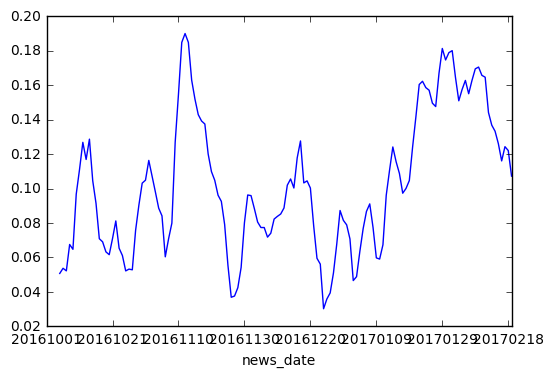

In [98]:
datagdelt.word2vec_corpus['w2v_16'].rolling(window=5,center=False).mean().plot()

In [18]:
import pandas as pd

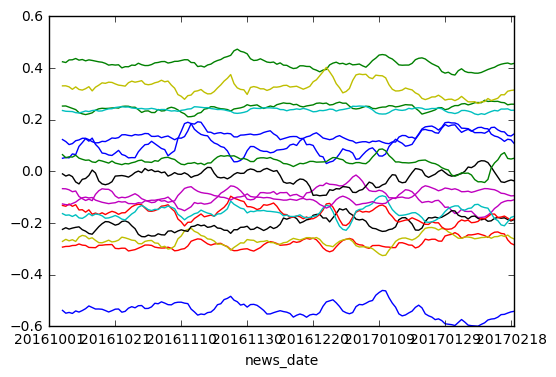

In [99]:
%matplotlib inline
#datagdelt.word2vec_corpus.plot()
datagdelt.word2vec_corpus.rolling(window=5,center=False).mean().plot(legend=False)

In [138]:
from sklearn.preprocessing import scale

In [154]:
aa=np.array(list(zip(tet.xdata['word2vec'][:,7],tet.ydata['word2vec'][:,2])))

In [136]:
scale()

array([[ 0.00526955, -0.03865752],
       [ 0.00633352, -0.05855961],
       [ 0.00778081,  0.05052215],
       [ 0.00544328,  0.0056867 ],
       [ 0.00297754, -0.03843859],
       [ 0.00636313,  0.05423986],
       [ 0.02077838, -0.14724669],
       [ 0.00996109,  0.01339578],
       [ 0.01218168, -0.03625068],
       [ 0.00904509,  0.00235076],
       [ 0.00356711, -0.03543105],
       [ 0.00191747,  0.07162833],
       [ 0.00794639,  0.02564352],
       [ 0.00939213, -0.01612966],
       [ 0.00823105, -0.00098516],
       [ 0.00042605,  0.05560814],
       [ 0.0071996 , -0.04467259],
       [ 0.00415225, -0.02039468],
       [ 0.0085867 , -0.03493847],
       [ 0.00678405, -0.03625201],
       [ 0.01050382, -0.00142168],
       [ 0.0093706 , -0.07889955],
       [ 0.01260253, -0.07534604],
       [ 0.00688435, -0.05074107],
       [ 0.00972573, -0.01902773],
       [ 0.00116689,  0.25337698],
       [ 0.01203185,  0.04396109],
       [ 0.01393189,  0.1295859 ],
       [ 0.02791836,

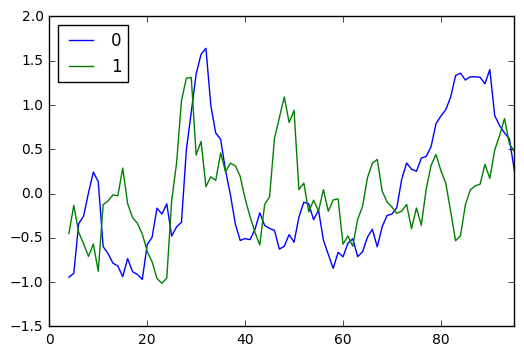

In [155]:
pd.DataFrame(scale(aa)).rolling(window=5,center=False).mean().plot()

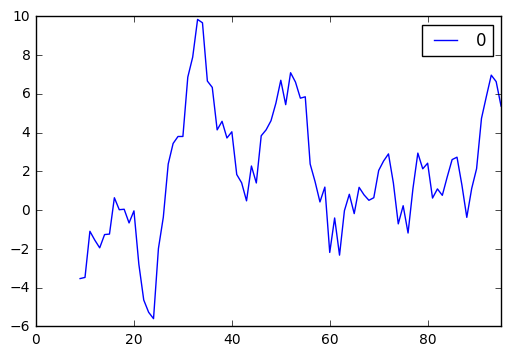

In [56]:
pd.DataFrame(tet.ydata['word2vec'][:,2]).rolling(window=10,center=False).mean().plot()

In [30]:
tet.prepare_data('word2vec')

BOOM! Now we have all of our datapoints with their nlp features neatly arranged in a pandas dataframe, ready for processing. Mission accomplished!

If we try to run this expensive preprocessing again on the same exact data...

In [8]:
datagdelt.gdelt_preprocess(vectrz='word2vec',size_w2v=8)

Using word2vec vectorization procedure
Nothing to be done, dataframes are up to date


Yay for savings!

Now we initialize the model training class, feeding it the dataframe from the nlp processing

## The model training module
This section covers model training, validation, and testing, from our model_training module

We initialize a class instance by loading into it two lists: one of names of your choosing and one of dataframes, which in this case is the output form the previous module above, datagdelt.vect_corpus_tfidf.

In [6]:
import model_training as mdlt
importlib.reload(mdlt)
tet=mdlt.StockPrediction([['word2vec'],[datagdelt.word2vec_corpus],[datagdelt.w2vec_model]],update=True)

Let's try an L1 linear regressor which is trying to predict the increase/decrease of tomorrow's S&P index over today's. We test on the last 20 days out of 50 and validate/tune, for every testing case, over the previous 10 days. As for the hyperparameters, we are letting our regularization parameter be searched for in the 0.001-3000 range and we allow for 40 iterations of the optimal parameter search.

In [7]:
tet.auto_ts_val_test_reg('word2vec','lasso',[['alpha',[0.001,7000.,60.]]],parm_search_iter=50,n_folds_val=20,
                         past_depth=30,n_folds_test=20,scaling=True,differential=True,notest=False,verbose=False,
                         eqdiff=False)

96
20
30
20


//anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameter choices: (777.7786666666666,)
model_test_rmse: 7.466 benchmark_test_rmse: 7.466
best parameter choices: (777.7786666666666,)
model_test_rmse: 13.611 benchmark_test_rmse: 13.611
best parameter choices: (777.7786666666666,)
model_test_rmse: 16.867 benchmark_test_rmse: 16.867
best parameter choices: (777.7786666666666,)
model_test_rmse: 3.337 benchmark_test_rmse: 3.337
best parameter choices: (777.7786666666666,)
model_test_rmse: 3.595 benchmark_test_rmse: 3.595
best parameter choices: (777.7786666666666,)
model_test_rmse: 15.351 benchmark_test_rmse: 15.351
best parameter choices: (777.7786666666666,)
model_test_rmse: 3.403 benchmark_test_rmse: 3.403
best parameter choices: (777.7786666666666,)
model_test_rmse: 0.653 benchmark_test_rmse: 0.653
best parameter choices: (777.7786666666666,)
model_test_rmse: 0.025 benchmark_test_rmse: 0.025
best parameter choices: (777.7786666666666,)
model_test_rmse: 15.245 benchmark_test_rmse: 15.245
best parameter choices: (777.7786666666666

[(6.9715473175452187, 5.3271630939674157),
 (6.9715473175452187, 5.3271630939674157)]

Well, the model clearly falls back on the benchmark, thanks to heavy L1 regularization. The coefficients are:

In [192]:
feat_imp=tet.models['word2vec'].coef_
feat_imp
#these are the feature importances for the lasso classifier

array([-0.,  0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
       -0., -0.,  0.,  0.,  0.])

...which isn't surprising. As we said at the beginning, the most important feature should have been today's closing, and it was, entirely offuscating everything else. (Except for the engineered after_weekend feature)

If one had gotten a reasonable result, they might want to play with feature importances to try and see which stems actually were the most significant. It can be done as follows

In [160]:
model=tet.w2v_models['word2vec']
model.similar_by_word('appl')

2017-02-20 12:13:06,546 : INFO : precomputing L2-norms of word weight vectors


[('iron', 0.9956756830215454),
 ('payment', 0.9955439567565918),
 ('auction', 0.9943109750747681),
 ('ipo', 0.9936873912811279),
 ('acquir', 0.992712676525116),
 ('diabet', 0.9926916360855103),
 ('app', 0.9923841953277588),
 ('exist', 0.9921814799308777),
 ('amazon', 0.9919903874397278),
 ('plebiscit', 0.9913445711135864)]

In [162]:
model.wv.similar_by_vector(-feat_imp[:-2])

[('palest', 0.6947636604309082),
 ('perrin', 0.6724652051925659),
 ('boynton', 0.671480655670166),
 ('seaman', 0.6704562902450562),
 ('handout', 0.6542955040931702),
 ('bother', 0.6467409729957581),
 ('ware', 0.6328902244567871),
 ('phinea', 0.618262767791748),
 ('aebaa', 0.6165940761566162),
 ('terro', 0.616300642490387)]

In [8]:
tet.auto_ts_val_test_reg('word2vec','ridge',[['alpha',[0.001,700000.,60.]]],parm_search_iter=50,n_folds_val=20,
                         past_depth=50,n_folds_test=20,scaling=True,differential=True,notest=False,verbose=False,
                         eqdiff=False)

96
20
50
20
best parameter choices: (17849999.97550003,)
model_test_rmse: 7.466 benchmark_test_rmse: 7.466
best parameter choices: (17849999.97550003,)
model_test_rmse: 13.611 benchmark_test_rmse: 13.611
best parameter choices: (17849999.97550003,)
model_test_rmse: 16.867 benchmark_test_rmse: 16.867
best parameter choices: (17849999.97550003,)
model_test_rmse: 3.337 benchmark_test_rmse: 3.337
best parameter choices: (17849999.97550003,)
model_test_rmse: 3.595 benchmark_test_rmse: 3.595
best parameter choices: (17849999.97550003,)
model_test_rmse: 15.351 benchmark_test_rmse: 15.351
best parameter choices: (17849999.97550003,)
model_test_rmse: 3.403 benchmark_test_rmse: 3.403
best parameter choices: (17849999.97550003,)
model_test_rmse: 0.653 benchmark_test_rmse: 0.653
best parameter choices: (999.695178472794,)
model_test_rmse: 1.012 benchmark_test_rmse: 0.025
best parameter choices: (1739.7768459256142,)
model_test_rmse: 15.632 benchmark_test_rmse: 15.245
best parameter choices: (1764.

[(7.1007497983829584, 5.3493104432500003),
 (6.9715473175452187, 5.3271630939674157)]

In [9]:
tet.auto_ts_val_test_reg('word2vec','ridge',[['alpha',[0.001,7000.,60.]]],parm_search_iter=50,n_folds_val=20,
                         past_depth=50,n_folds_test=20,scaling=False,differential=False,notest=True,verbose=False,
                         eqdiff=False)

96
0
50
20


array([ 2351.29976527])

Hmmm... Not sure what to make of this

How about we try a random forest regressor instead? We are letting our tuning select any combination among 5 values for the number of estimators, 5 for the maximum number of features used for splitting, and we allow a maximum depth from 5 to 7.

In [218]:
tet.auto_ts_val_test_reg('word2vec','rfreg',[['n_estim',{10,}],['max_feat',{5,6,7,8,9,10}],['max_depth',{4,5,6,7,8,9}]],
                         parm_search_iter=1,n_folds_val=25,past_depth=20,n_folds_test=20,scaling=True,differential=True,
                         verbose=False,notest=False,eqdiff=False)

best parameter choices: (10, 5, 4)
model_test_rmse: 1.612 benchmark_test_rmse: 7.466
best parameter choices: (10, 7, 5)
model_test_rmse: 14.001 benchmark_test_rmse: 13.611
best parameter choices: (10, 10, 7)
model_test_rmse: 17.706 benchmark_test_rmse: 16.867
best parameter choices: (10, 10, 6)
model_test_rmse: 5.229 benchmark_test_rmse: 3.337
best parameter choices: (10, 6, 6)
model_test_rmse: 2.823 benchmark_test_rmse: 3.595
best parameter choices: (10, 7, 6)
model_test_rmse: 10.927 benchmark_test_rmse: 15.351
best parameter choices: (10, 5, 7)
model_test_rmse: 5.252 benchmark_test_rmse: 3.403
best parameter choices: (10, 7, 8)
model_test_rmse: 8.943 benchmark_test_rmse: 0.653
best parameter choices: (10, 7, 5)
model_test_rmse: 1.406 benchmark_test_rmse: 0.025
best parameter choices: (10, 5, 6)
model_test_rmse: 13.114 benchmark_test_rmse: 15.245
best parameter choices: (10, 8, 4)
model_test_rmse: 1.408 benchmark_test_rmse: 6.362
best parameter choices: (10, 9, 9)
model_test_rmse: 2.7

[(7.0927961853484476, 5.1260596225232478),
 (6.9715473175452187, 5.3271630939674157)]

Now, if we want to get a prediction for today, we toggle the 'notest' attribute to True

In [10]:
tet.auto_ts_val_test_reg('word2vec','rfreg',[['n_estim',{10,}],['max_feat',{5,6,7,8,9,10}],['max_depth',{4,5,6,7,8,9}]],
                         parm_search_iter=1,n_folds_val=25,past_depth=20,n_folds_test=20,scaling=True,differential=True,
                         verbose=False,notest=True,eqdiff=False)

96
0
20
25


array([ 2359.4078854])

In [221]:
feat_imp=tet.models['word2vec'].feature_importances_
feat_imp
#these are the feature importances for a random forest classifier

array([ 0.06367856,  0.20311588,  0.04593268,  0.12812747,  0.00645739,
        0.0082692 ,  0.01786857,  0.05933176,  0.05816249,  0.11486349,
        0.04174018,  0.12358353,  0.00782916,  0.02930216,  0.01698054,
        0.00402597,  0.04262157,  0.02810939])

In [1]:
import datetime
print(datetime.datetime.utcnow())
print(datetime.date.today())





datetime.datetime(2017, 2, 22, 0, 31, 45, 410865)

In [14]:
datetime.datetime.utcnow().strftime("%Y-%m-%d")

'2017-02-22'

In [8]:
datetime.date.

TypeError: today() takes no arguments (1 given)

In [11]:
tet.auto_ts_val_test_reg('word2vec','knnreg',[['numb_nn',{2,3,4,5,6,7,8,9,10}]],parm_search_iter=1,n_folds_val=15,
                         n_folds_test=35,past_depth=20,scaling=True,differential=True,notest=False,verbose=False,
                         eqdiff=False)

96
35
20
15
best parameter choices: (10,)
model_test_rmse: 3.694 benchmark_test_rmse: 1.998
best parameter choices: (10,)
model_test_rmse: 12.462 benchmark_test_rmse: 11.736
best parameter choices: (10,)
model_test_rmse: 18.602 benchmark_test_rmse: 17.880
best parameter choices: (10,)
model_test_rmse: 12.478 benchmark_test_rmse: 11.521
best parameter choices: (10,)
model_test_rmse: 2.183 benchmark_test_rmse: 3.327
best parameter choices: (10,)
model_test_rmse: 7.532 benchmark_test_rmse: 6.454
best parameter choices: (10,)
model_test_rmse: 13.321 benchmark_test_rmse: 9.703
best parameter choices: (10,)
model_test_rmse: 3.278 benchmark_test_rmse: 1.480
best parameter choices: (10,)
model_test_rmse: 3.377 benchmark_test_rmse: 4.962
best parameter choices: (10,)
model_test_rmse: 5.701 benchmark_test_rmse: 6.409
best parameter choices: (10,)
model_test_rmse: 5.804 benchmark_test_rmse: 2.761
best parameter choices: (10,)
model_test_rmse: 10.472 benchmark_test_rmse: 8.227
best parameter choic

[(6.8453165666666536, 5.2300295112219395),
 (6.9849111052740875, 4.9443270221840132)]

In [12]:
tet.auto_ts_val_test_reg('word2vec','knnreg',[['numb_nn',{3,4,5,6}]],parm_search_iter=10,n_folds_val=15,
                         n_folds_test=15,past_depth=30,scaling=True,differential=True,notest=True,verbose=False)

96
0
30
15


array([ 2356.119873])

In [13]:
tet.auto_ts_val_test_class('word2vec','logreg',[['l1orl2?',{'l1','l2'}],['C',[0.0001,100.,0.3]]],
                           parm_search_iter=30,n_folds_val=20,n_folds_test=20,past_depth=50,scaling=False,notest=False,
                           verbose=False)

96
20
50
20
best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 66.66669999999999)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: ('l1', 44.444500000000005)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: ('l1', 36.89992592592593)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 33.3334)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 55.555600000000005)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 24.965781481481486)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 34.56796666666666)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices

[(array([[ 0.8,  0.8,  0.6]]),
  array([[ 0.4       ,  0.4       ,  0.48989795]])),
 (array([[ 0.65,  0.9 ,  0.55]]),
  array([[ 0.4769696 ,  0.3       ,  0.49749372]]))]

In [14]:
tet.auto_ts_val_test_class('word2vec','logreg',[['l1orl2?',{'l1','l2'}],['C',[0.0001,100.,0.3]]],
                           parm_search_iter=30,n_folds_val=20,n_folds_test=20,past_depth=50,scaling=False,notest=True,
                           verbose=False)

96
0
50
20


array([ 1.])

In [21]:
feat_imp=tet.models['word2vec'].coef_
print(feat_imp)
model=tet.w2v_models['word2vec']
model.wv.similar_by_vector(np.array(feat_imp[:-2]))
#these are the feature importances for the lasso classifier

[[ -1.25623890e+01   0.00000000e+00   1.45077640e+01  -1.17392325e+01
   -5.54032834e+00   0.00000000e+00  -1.78744693e+01  -1.57152561e+01
   -4.34425475e+00  -1.65644768e+00   0.00000000e+00   0.00000000e+00
    8.33683954e+00   0.00000000e+00   0.00000000e+00  -1.79039296e+01
   -9.36753961e-01  -1.05947357e-02   9.04486174e-03  -6.67503162e-03]]


error: failed in converting 1st argument `x' of _fblas.dnrm2 to C/Fortran array

In [20]:
model.wv.similar_by_vector(np.array([-0.25653017, -0.10820102,  0.0424006 ,0.09318788, -0.06273134,0.02189363, -0.05919369,  0.02997402, -0.0042966 , -0.27152437,0.05229396, -0.00672993, -0.00525654, -0.08703346, -0.09726489,0.10277114]))

[('poo', 1.0),
 ('beam', 0.9922065138816833),
 ('toyota', 0.9903239011764526),
 ('fiji', 0.9890756607055664),
 ('singh', 0.9884848594665527),
 ('wast', 0.9880532026290894),
 ('zika', 0.9878035187721252),
 ('deserv', 0.9877070188522339),
 ('religion', 0.9873846769332886),
 ('harm', 0.9872298240661621)]

In [179]:
tet.auto_ts_val_test_class('word2vec','logreg',[['l1orl2?',{'l1','l2'}],['C',[0.0001,100.,0.3]]],
                           parm_search_iter=30,n_folds_val=20,n_folds_test=20,past_depth=50,scaling=False,notest=False,
                           verbose=False)

best parameter choices: ('l1', 0.0001)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 44.444500000000005)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: ('l1', 44.444500000000005)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: ('l1', 37.0371)
test_rec,prec,F1: [1.0, 0.0, 0.0] benchmark_rec,prec,F1: [1.0, 0.0, 0.0]
best parameter choices: ('l1', 38.88893)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 66.66669999999999)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 55.555600000000005)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: ('l1', 49.38276666666667)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: ('l1', 44.444500000

[(array([[ 0.85,  0.85,  0.7 ]]),
  array([[ 0.35707142,  0.35707142,  0.45825757]])),
 (array([[ 0.65,  0.9 ,  0.55]]),
  array([[ 0.4769696 ,  0.3       ,  0.49749372]]))]

Let's see if classifying tomorrow's value going up or down will do us and better...
N.B. We need to specify a decision threshold which I recommend leaving at 0.5 for now.

In [171]:
tet.auto_ts_val_test_class('word2vec','rfclass',[['n_estim',{1,2,3,4,5}],['max_feat',{8,9,10}],
                                                 ['max_depth',{2,3,4,5}]],parm_search_iter=1,n_folds_val=20,
                           past_depth=40,n_folds_test=15,scaling=False,notest=False,verbose=False)

best parameter choices: (1, 9, 3)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (3, 10, 5)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (1, 9, 3)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: (1, 9, 3)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: (2, 9, 5)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: (3, 8, 5)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (2, 8, 5)
test_rec,prec,F1: [1.0, 1.0, 1.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: (5, 9, 4)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [0.0, 1.0, 0.0]
best parameter choices: (3, 9, 4)
test_rec,prec,F1: [0.0, 1.0, 0.0] benchmark_rec,prec,F1: [1.0, 1.0, 1.0]
best parameter choices: (3, 8, 3)
te

[(array([[ 0.66666667,  1.        ,  0.66666667]]),
  array([[ 0.47140452,  0.        ,  0.47140452]])),
 (array([[ 0.66666667,  0.93333333,  0.6       ]]),
  array([[ 0.47140452,  0.24944383,  0.48989795]]))]

Good! Our model overperform the benchmark as for accuracy (=F1 in this case): 0.67 vs 0.60.

Now let's predict what today's closing is going to be!

In [172]:
tet.auto_ts_val_test_class('word2vec','rfclass',[['n_estim',{1,2,3,4,5}],['max_feat',{8,9,10}],
                                                 ['max_depth',{2,3,4,5}]],parm_search_iter=1,n_folds_val=20,
                           past_depth=40,n_folds_test=15,scaling=False,notest=True,verbose=False)

array([ 1.])

It will go up, apparently!

In [175]:
feat_imp=tet.models['word2vec'].feature_importances_
feat_imp
#remember: only the first n-2 features are nlp, the (n-1)-th is being after a weekend and the n-th is today's closing

array([ 0.01150188,  0.        ,  0.        ,  0.04061601,  0.        ,
        0.16298408,  0.32183145,  0.06389972,  0.        ,  0.06375228,
        0.12311446,  0.21230012])

In [ ]:
tet.auto_ts_val_test_class('word2vec','svmclass',[['C',[0.000001,1.,0.001]],['kernel',{'poly','linear'}]],
                           parm_search_iter=15,past_depth=30,n_folds_val=15,n_folds_test=15,scaling=False,notest=False,
                           verbose=False)

And now, for the real deal: k-fold training and validation!
The following method performs that in a very general manner. It lets you decide what regression model to choose, as well as the values of the hyperparameters (please see the module documentation in model_training.py for details on how to pass the hyperparameters), also you need to supply the number of folds you want your data split into, and a seed, for reproducibility. There is also an option to scale and normalize the features but it doesn't quite perform well in general.

The method returns the model average performance over the k training iterations. In short, tuning will consist of choosing the value for the hyperparameters that optimizes avg_validation_rmse (that is minimize the average root mean squared on the validation datasets)

By chance, in this one case we outperform the benchmark model with a lower rmse, but this procedure should be performed a couple of time and an average final performance should be quoted instead.

Out of curiosity, let's see what the most important features were.

As you can see, the method returns again average validation performances which are now measured in terms of recall, precision, and F1 score. In lack of a specific metric we want to optimize, we are going to use the F1 score for tuning.

The performance plateaus and is optimal for alpha ~1.0

Bingo! Our model predicts all 1's. Not much gained...

Incidentally anyway, that's how you pull the predictions vector for a specific dataset.
In the future I'll give the option to save a specific model run instead of overwriting. Good for free exploration.

# Scratch from now on, please ignore!!

## Trying out different regressors on the data, no luck so far :(